# Brazil COVID-19 analysis

This notebook is part of Alura's courses [Análise de série temporal: COVID-19 (Time series analysis: COVID-19)]((https://cursos.alura.com.br/course/analise-serie-temporal-covid-19)) and [Previsões de série temporal: COVID-19 (Time series predictions: COVID-19)](https://cursos.alura.com.br/course/previsoes-serie-temporal-covid-19) by Sara Malvar.

All the code was written in Python 3, using Jupyter notebooks.

**For more info, check the README.**

In [1]:
# Importing libraries

from datetime import date
import itertools
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller

from utils.processing import creating_features
from utils.visualization import barplot, lineplot, plotACF, plotting

In [2]:
# Set to ignore warnings

warnings.filterwarnings('ignore')

# Exploratory data analysis

In [3]:
# Importing the data

df = pd.read_csv('c:\cases-brazil-states.csv')

Let's take a look at the data.

In [4]:
df.head()

,semana,data,pais,estado,cidade,novosObitos,Obitos,novosCasos,Casos,obitosMS,casosMS,obitos_por_100k,casos_por_100k,obitos_por_casos,recuperados,suspeitos,testes,testes_por_100k
0,9,2020-02-25,Brazil,SP,TOTAL,0,0,1,1,0,0,0.0,0.00218,0.0,NaN,NaN,NaN,NaN
1,9,2020-02-25,Brazil,TOTAL,TOTAL,0,0,1,1,0,0,0.0,0.00048,0.0,NaN,NaN,NaN,NaN
2,9,2020-02-26,Brazil,SP,TOTAL,0,0,0,1,0,1,0.0,0.00218,0.0,NaN,NaN,NaN,NaN
3,9,2020-02-26,Brazil,TOTAL,TOTAL,0,0,0,1,0,1,0.0,0.00048,0.0,NaN,NaN,NaN,NaN
4,9,2020-02-27,Brazil,SP,TOTAL,0,0,0,1,0,1,0.0,0.00218,0.0,NaN,NaN,NaN,NaN


We can see some records in the column 'estado' as TOTAL, but we want to see data from each Brazilian state individually, so let's select those rows which are not 'TOTAL'. 

In [5]:
df_filtered = df[df["estado"] != "TOTAL"]

Now we need to check data types.

In [6]:
df_filtered.dtypes

semana                int64
data                 object
pais                 object
estado               object
cidade               object
novosObitos           int64
Obitos                int64
novosCasos            int64
Casos                 int64
obitosMS              int64
casosMS               int64
obitos_por_100k     float64
casos_por_100k      float64
obitos_por_casos    float64
recuperados         float64
suspeitos           float64
testes              float64
testes_por_100k     float64
dtype: object

The column "data" was interpreted as an object, but this feature is a DateTime format, so let's convert it to the correct data type.

In [7]:
df_filtered["data"] = df["data"].astype('datetime64[ns]')

In [8]:
df_filtered.dtypes

semana                       int64
data                datetime64[ns]
pais                        object
estado                      object
cidade                      object
novosObitos                  int64
Obitos                       int64
novosCasos                   int64
Casos                        int64
obitosMS                     int64
casosMS                      int64
obitos_por_100k            float64
casos_por_100k             float64
obitos_por_casos           float64
recuperados                float64
suspeitos                  float64
testes                     float64
testes_por_100k            float64
dtype: object

Let's check for null values and then look at the main df's statistics and shape.

In [9]:
df_filtered.isna().sum()

semana                 0
data                   0
pais                   0
estado                 0
cidade                 0
novosObitos            0
Obitos                 0
novosCasos             0
Casos                  0
obitosMS               0
casosMS                0
obitos_por_100k        0
casos_por_100k         0
obitos_por_casos       0
recuperados          695
suspeitos            772
testes              1283
testes_por_100k     1283
dtype: int64

In [10]:
df.shape

(3962, 18)

In [11]:
df_filtered.describe()

,semana,novosObitos,Obitos,novosCasos,Casos,obitosMS,casosMS,obitos_por_100k,casos_por_100k,obitos_por_casos,recuperados,suspeitos,testes,testes_por_100k
count,3804.000000,3804.000000,3804.000000,3804.000000,3804.000000,3804.000000,3804.000000,3804.000000,3804.000000,3804.000000,3109.000000,3032.000000,2.521000e+03,2521.000000
mean,21.274185,24.376446,1134.015247,702.011304,26364.892219,1130.110673,26238.123028,15.013779,486.004081,0.034772,20238.803795,20370.550792,9.479935e+04,1779.965295
std,5.848401,49.220415,2585.371829,1282.620498,50126.588822,2583.485812,50047.137269,20.416471,750.791881,0.026541,37238.544528,46057.401026,1.447486e+05,1927.148168
min,9.000000,-37.000000,0.000000,-290.000000,1.000000,0.000000,0.000000,0.000000,0.002180,0.000000,1.000000,1.000000,8.540000e+02,36.761660
25%,16.000000,1.000000,16.000000,31.750000,466.000000,15.000000,452.750000,0.371652,9.411598,0.018953,429.000000,436.500000,1.763000e+04,368.700830
50%,21.000000,7.000000,197.500000,246.500000,6464.000000,194.500000,6342.500000,4.277300,128.924800,0.029210,4333.000000,2269.000000,4.942000e+04,1118.932160
75%,26.000000,26.000000,995.500000,899.250000,32962.250000,979.500000,32722.500000,23.465443,703.621617,0.044360,23695.000000,11732.000000,1.191410e+05,2539.741470
max,31.000000,434.000000,22997.000000,19030.000000,542304.000000,22997.000000,542304.000000,84.686860,5401.965460,0.222220,351610.000000,340112.000000,1.788225e+06,10528.715860


We can see a relevant number of null values for the 'recuperados', 'suspeitos', 'testes', and 'testes_por_100k' columns, but there is a reason for that. This lack of information is mainly concentrated in the first days of COVID-19 infection and there were no recovered ones and suspicious cases due to the disease's early stages and some methodologies were still being defined. So we should not drop these rows.   

# COVID-19 mortality over time

Let's check the COVID-19 mortality over time.  

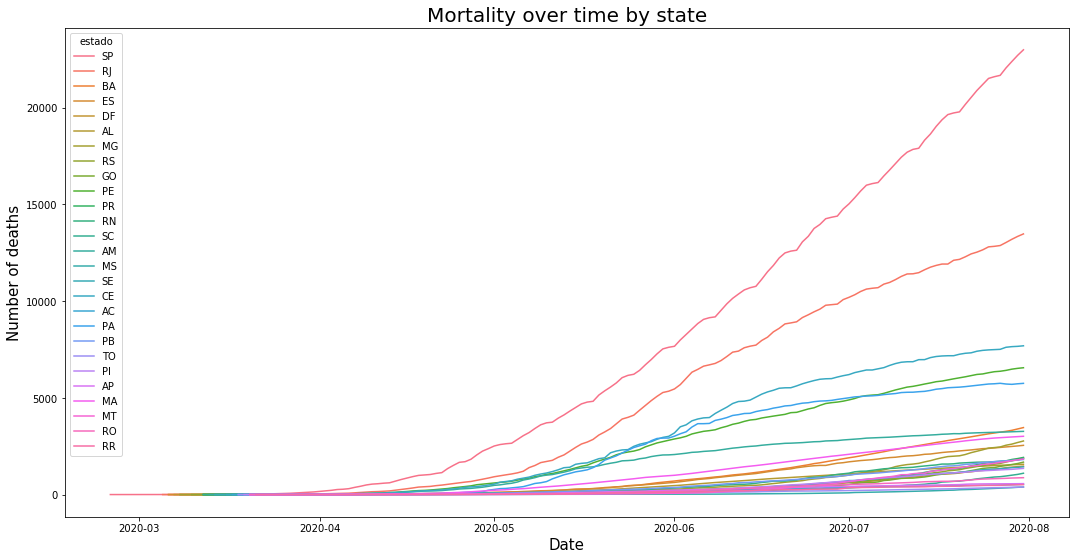

In [12]:
# Plotting number of deaths over time

lineplot(df_filtered, "data", "Obitos", "estado", "Date", "Number of deaths", "Mortality over time by state")

Since Brazil have 27 states and São Paulo has the highest number of deaths, we are going to create a data frame with only SP records and look at its number over time. 

In [13]:
df_sp = df_filtered[df_filtered["estado"] == "SP"]
df_sp.head()

,semana,data,pais,estado,cidade,novosObitos,Obitos,novosCasos,Casos,obitosMS,casosMS,obitos_por_100k,casos_por_100k,obitos_por_casos,recuperados,suspeitos,testes,testes_por_100k
0,9,2020-02-25,Brazil,SP,TOTAL,0,0,1,1,0,0,0.0,0.00218,0.0,NaN,NaN,NaN,NaN
2,9,2020-02-26,Brazil,SP,TOTAL,0,0,0,1,0,1,0.0,0.00218,0.0,NaN,NaN,NaN,NaN
4,9,2020-02-27,Brazil,SP,TOTAL,0,0,0,1,0,1,0.0,0.00218,0.0,NaN,NaN,NaN,NaN
6,9,2020-02-28,Brazil,SP,TOTAL,0,0,1,2,0,1,0.0,0.00436,0.0,NaN,NaN,NaN,NaN
8,9,2020-02-29,Brazil,SP,TOTAL,0,0,0,2,0,2,0.0,0.00436,0.0,NaN,NaN,NaN,NaN


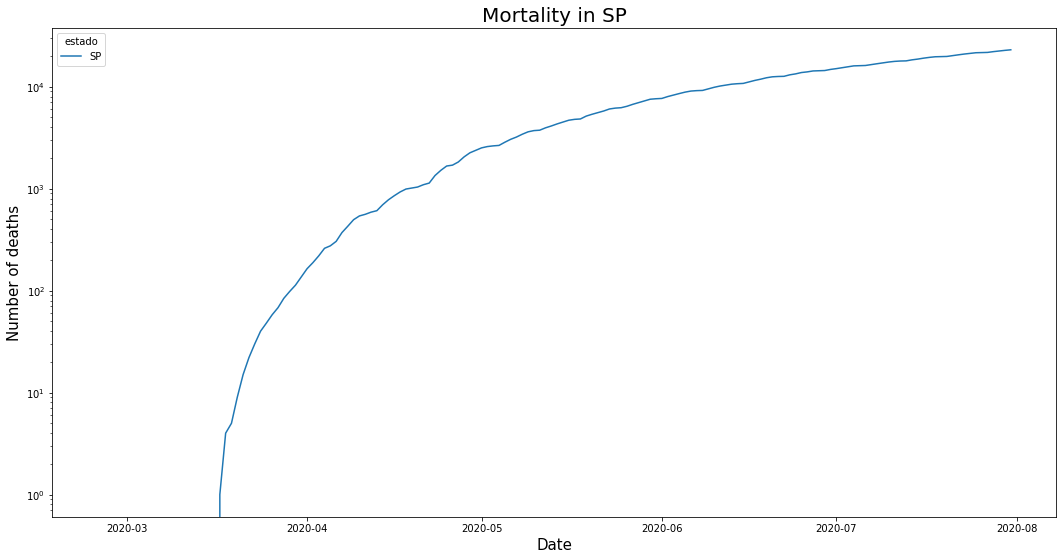

In [14]:
# Plotting number of deaths over time in SP

lineplot(df_sp, "data", "Obitos", "estado", "Date", "Number of deaths", "Mortality in SP", "y")

Analyzing these two plots, we can confirm that São Paulo state (so does the rest of the country) has an exponential COVID-19 death rate since the second graph did not reach the plateau-ish shape.

Let's also expand this analysis to COVID-19 recovered ones, the number of suspicious cases, and deaths all combined. 

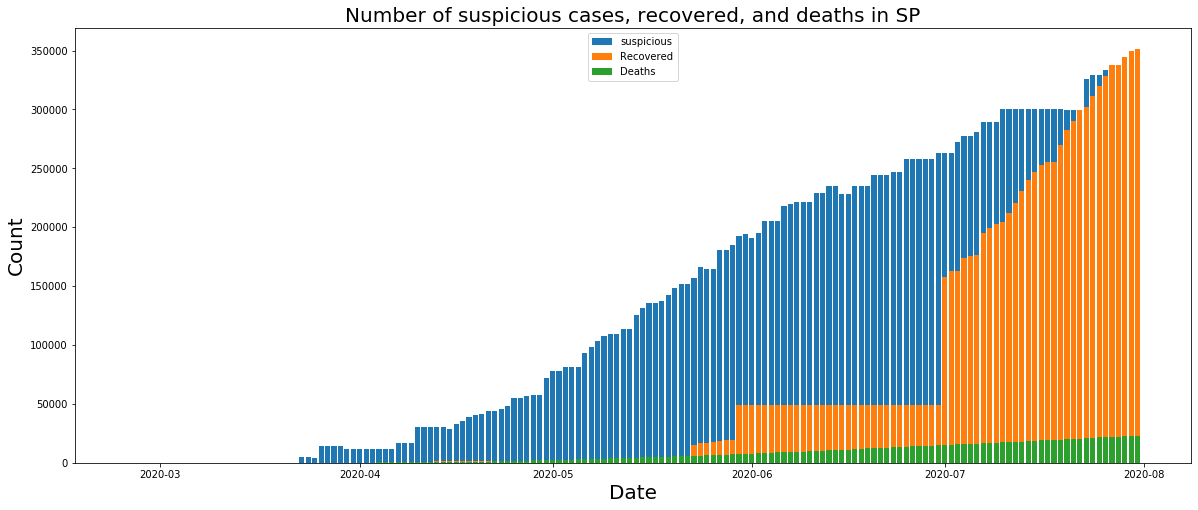

In [15]:
# Plotting number of deaths over time in SP

plt.figure(figsize = (20,8))
fig = plt.bar(df_sp["data"], df_sp["suspeitos"], label = "suspicious")
plt.bar(df_sp["data"], df_sp["recuperados"], label = "Recovered")
plt.bar(df_sp["data"], df_sp["Obitos"], label = "Deaths")
plt.title("Number of suspicious cases, recovered, and deaths in SP", fontsize=20)
plt.xlabel("Date", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.legend()

In June, the number of recovered ones did not change due to the change in methodology. Before 06/01/20, the government only considered recovered ones those who have been hospitalized and later had a medical discharge. After that, they start to consider also those who have got COVID and did not go to the hospital. We need to take this into consideration before we analyze this feature because we cannot apply the same analysis in both periods. 

Now, we are going to check the daily growth rate for the number of new cases and deaths. 

In [16]:
# Creating new columns for growth rate

df_sp["aceleracao_casos"] = df_sp["novosCasos"].diff()
df_sp["aceleracao_obitos"] = df_sp["novosObitos"].diff()

In [17]:
df_sp.tail()

,semana,data,pais,estado,cidade,novosObitos,Obitos,novosCasos,Casos,obitosMS,casosMS,obitos_por_100k,casos_por_100k,obitos_por_casos,recuperados,suspeitos,testes,testes_por_100k,aceleracao_casos,aceleracao_obitos
3847,31,2020-07-27,Brazil,SP,TOTAL,70,21676,3672,487654,21676,487654,47.20481,1061.98628,0.04445,337434.0,333078.0,1158851.0,2523.68249,-829.0,-19.0
3875,31,2020-07-28,Brazil,SP,TOTAL,383,22059,12647,500301,21676,487654,48.03889,1089.52823,0.04409,337434.0,334977.0,1158851.0,2523.68249,8975.0,313.0
3903,31,2020-07-29,Brazil,SP,TOTAL,330,22389,13896,514197,22389,514197,48.75754,1119.79018,0.04354,344501.0,340112.0,1158851.0,2523.68249,1249.0,-53.0
3931,31,2020-07-30,Brazil,SP,TOTAL,321,22710,14809,529006,22710,529006,49.45660,1152.04041,0.04293,349287.0,340112.0,1788225.0,3894.29886,913.0,-9.0
3959,31,2020-07-31,Brazil,SP,TOTAL,287,22997,13298,542304,22997,542304,50.08161,1181.00007,0.04241,351610.0,340112.0,1788225.0,3894.29886,-1511.0,-34.0


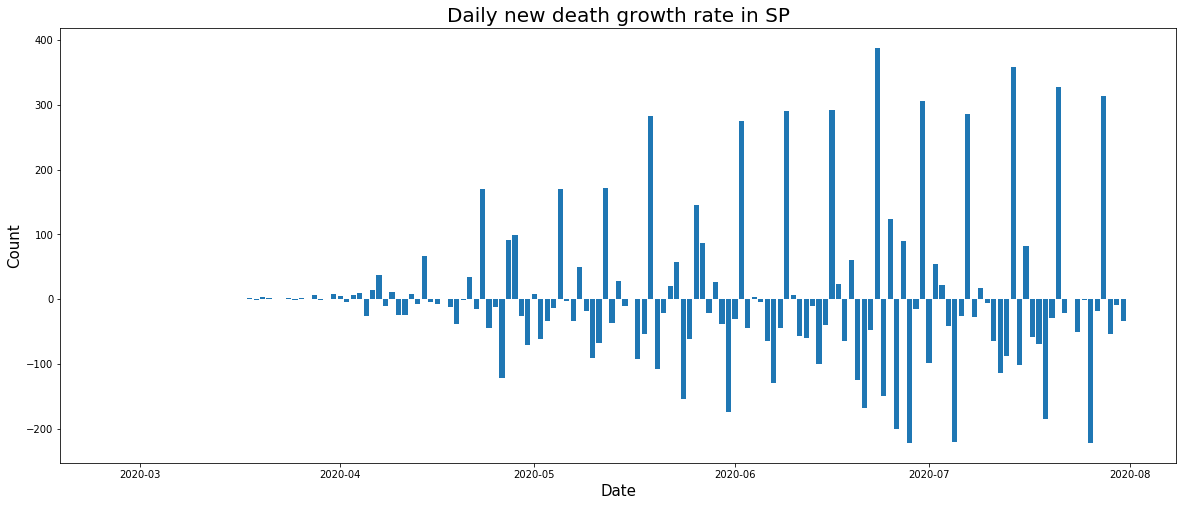

In [18]:
# Plotting daily new deaths growth rate

barplot(df_sp, "data", "aceleracao_obitos", "Date", "Count", "Daily new death growth rate in SP")

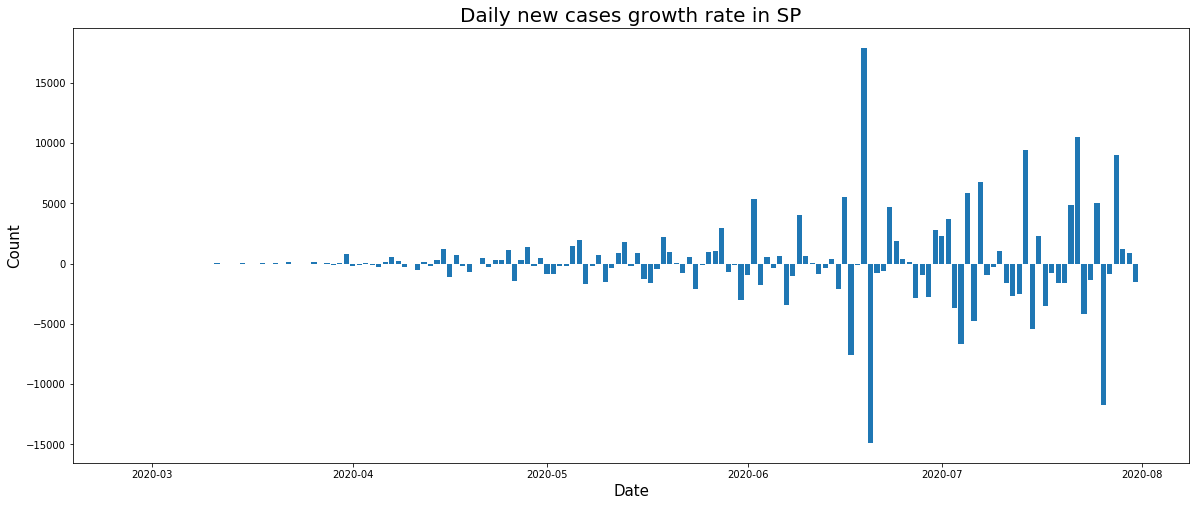

In [19]:
# Plotting daily new cases growth rate

barplot(df_sp, "data", "aceleracao_casos", "Date", "Count", "Daily new cases growth rate in SP")

In both graphs, we see weekly seasonality due to the lack of updates of new cases/death during the weekend, and all these records are released at once on Mondays, impacting the growth rate. To avoid the fluctuations, we will use a moving average of 7 and 14 days (quarantine time) to detect the mortality trend.

In [20]:
# Creating 2 new columns for moving average

df_sp["media_movel_mortes_7_dias"] = df_sp["novosObitos"].rolling(7, center=False).mean()
df_sp["media_movel_mortes_14_dias"] = df_sp["novosObitos"].rolling(14, center=False).mean()

<BarContainer object of 158 artists>

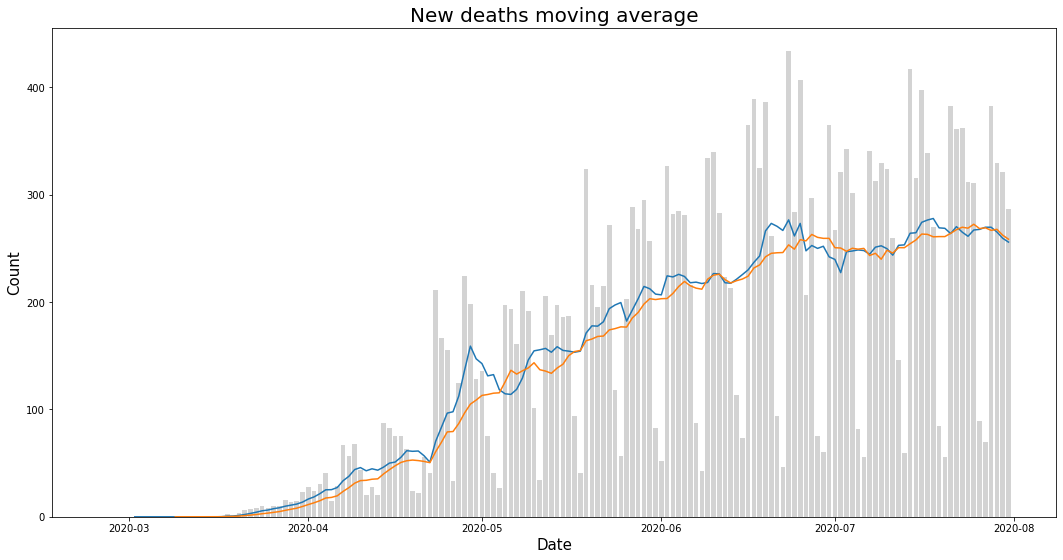

In [21]:
# Plotting moving average

lineplot(df_sp, "data", "media_movel_mortes_7_dias", None, "Date", "Count", "New deaths moving average")
lineplot(df_sp, "data", "media_movel_mortes_14_dias", None, "Date", "Count", "New deaths moving average")
plt.bar(df_sp["data"], df_sp["novosObitos"], color = "lightgrey")

We see that the number of new deaths reached a plateau-ish shape, which indicates a decreasing number of deaths in the next few months.  

In [22]:
df_sp['mes'] = pd.to_datetime(df_sp['data'])
df_sp['dia_da_semana'] = df_sp['mes'].dt.day_name() # A FUNÇÃO weekday_name FOI SUBSTITUÍDA POR 
df_sp.head()

X, y = creating_features(df_sp,label='Obitos')
df_final = pd.concat([X,y],axis=1)

In [23]:
df_sp

,semana,data,pais,estado,cidade,novosObitos,Obitos,novosCasos,Casos,obitosMS,...,recuperados,suspeitos,testes,testes_por_100k,aceleracao_casos,aceleracao_obitos,media_movel_mortes_7_dias,media_movel_mortes_14_dias,mes,dia_da_semana
0,9,2020-02-25,Brazil,SP,TOTAL,0,0,1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-25,Tuesday
2,9,2020-02-26,Brazil,SP,TOTAL,0,0,0,1,0,...,NaN,NaN,NaN,NaN,-1.0,0.0,NaN,NaN,2020-02-26,Wednesday
4,9,2020-02-27,Brazil,SP,TOTAL,0,0,0,1,0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,2020-02-27,Thursday
6,9,2020-02-28,Brazil,SP,TOTAL,0,0,1,2,0,...,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,2020-02-28,Friday
8,9,2020-02-29,Brazil,SP,TOTAL,0,0,0,2,0,...,NaN,NaN,NaN,NaN,-1.0,0.0,NaN,NaN,2020-02-29,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3847,31,2020-07-27,Brazil,SP,TOTAL,70,21676,3672,487654,21676,...,337434.0,333078.0,1158851.0,2523.68249,-829.0,-19.0,269.714286,269.214286,2020-07-27,Monday
3875,31,2020-07-28,Brazil,SP,TOTAL,383,22059,12647,500301,21676,...,337434.0,334977.0,1158851.0,2523.68249,8975.0,313.0,269.714286,266.785714,2020-07-28,Tuesday
3903,31,2020-07-29,Brazil,SP,TOTAL,330,22389,13896,514197,22389,...,344501.0,340112.0,1158851.0,2523.68249,1249.0,-53.0,265.285714,267.785714,2020-07-29,Wednesday
3931,31,2020-07-30,Brazil,SP,TOTAL,321,22710,14809,529006,22710,...,349287.0,340112.0,1788225.0,3894.29886,913.0,-9.0,259.428571,262.285714,2020-07-30,Thursday


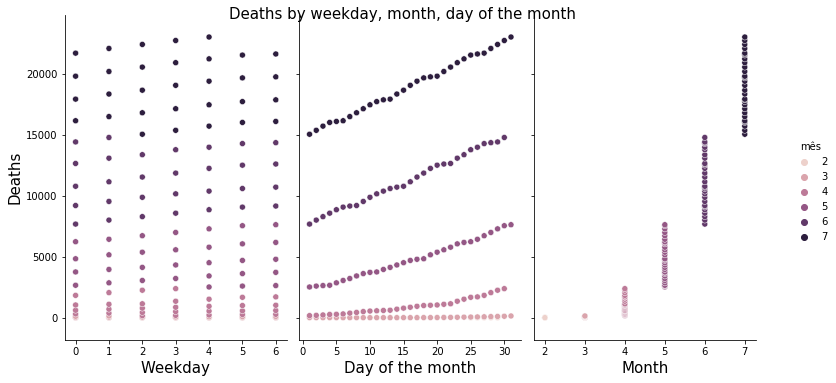

In [24]:
g = sns.pairplot(df_final.dropna(),
                hue='mês',
                x_vars=['diasemana','diamês','mês'],
                y_vars='Obitos')

g.fig.set_size_inches(12,6)
g.axes[0,0].set_xlabel('Weekday',fontsize=15)
g.axes[0,1].set_xlabel('Day of the month',fontsize=15)
g.axes[0,2].set_xlabel('Month',fontsize=15)
g.axes[0,0].set_ylabel('Deaths',fontsize=15)

plt.suptitle('Deaths by weekday, month, day of the month',fontsize=15)
plt.show()

All these three graphs confirm our thesis of exponential COVID-19 deaths:
1. the leftmost graph tells us the number of deaths divided into weekdays. Over time, we can see that the dots are more scattered from each other which tells us that, after seven days, the number of victims grew rapidly.
2. the graph in the center is similar to the former one but the data is divided into the day of the month, and we see the same pattern of rapid growth over time since the "slope" is high.
3. the rightmost graph is divided into months and we see that in February and March the dots are over each other, and then they start to be more scattered, which is a sign of how fast the number of deaths is increasing.

# Autocorrelation and partial autocorrelation

The autocorrelation function (ACF) is the linear correlation between data in the same time series. That is, how much the value on the 10th day after the reference date (usually the first record in the dataset) is correlated with the first or second day for example.

Partial autocorrelation (PACF) is the correlation in a time series that is not explained by the other mutual autocorrelations, such as trend and seasonality. In other words, PACF is the autocorrelation between the observed data and the residuals.

Both ACF and PACF are used to see if an observation in a time series with observations at prior time steps with the relationships of intervening observations is removed. ([source](https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/#:~:text=A%20partial%20autocorrelation%20is%20a,relationships%20of%20intervening%20observations%20removed.)).

## Mortality autocorrelation

Now, let's search for new and total deaths autocorrelation.

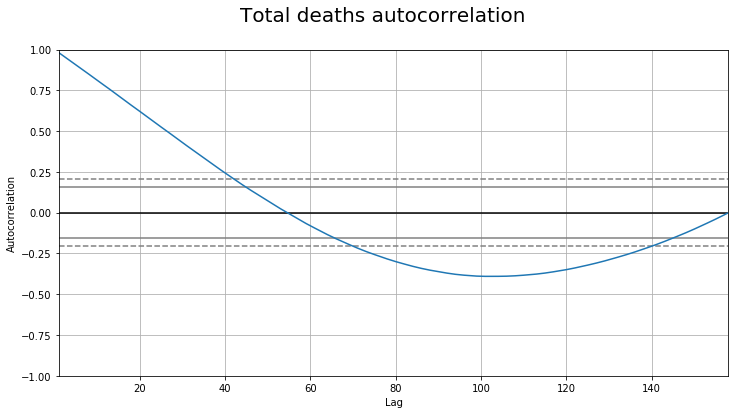

In [25]:
# Plotting total deaths autocorrelation

ax = plt.figure(figsize=(12,6))
ax.suptitle("Total deaths autocorrelation", ha = "center", size=20)
autocorrelation_plot(df_sp["Obitos"])
ax = ax

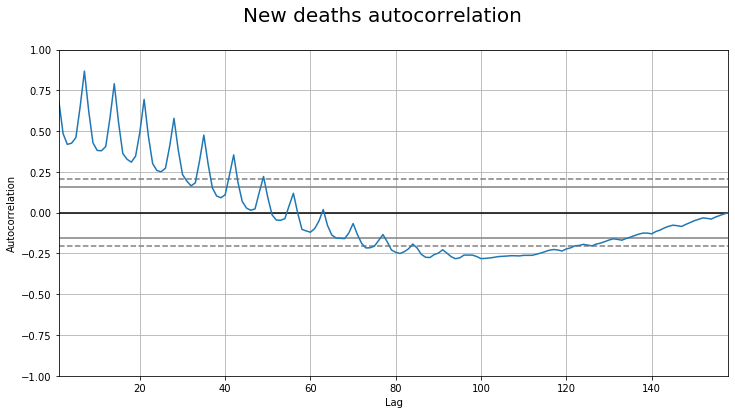

In [26]:
# Plotting new deaths autocorrelation

ax = plt.figure(figsize=(12,6))
ax.suptitle("New deaths autocorrelation", ha = "center", size=20)
autocorrelation_plot(df_sp["novosObitos"])
ax = ax

 In the first graph, we see that within 1 and 2 weeks, the deaths are highly autocorrelated to each other, and, as time goes by, this correlation decreases and even becomes negative at around 55th lag. At this point, the number of deaths does not correlate because at the beginning of the pandemic we saw a low number of victims and then the numbers skyrocketed. If the numbers stayed the same, i.e., zero growth rate, we would have a high autocorrelation all along. Thus, mortality is rapidly growing.

In the second one, we see spikes due to the seasonality of around every 7 days but it is clear also that the same trend happens here, as time lag increases the autocorrelation decreases. To avoid the effect of seasonality, we need to see the autocorrelations for 7-day new deaths moving average.

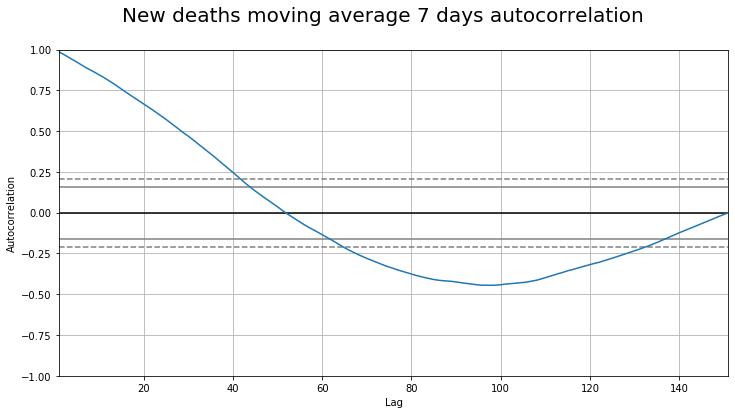

In [27]:
# Plotting new deaths moving average autocorrelation

ax = plt.figure(figsize=(12,6))
ax.suptitle("New deaths moving average 7 days autocorrelation", ha = "center", size=20)
autocorrelation_plot(df_sp["media_movel_mortes_7_dias"][7:])
ax = ax

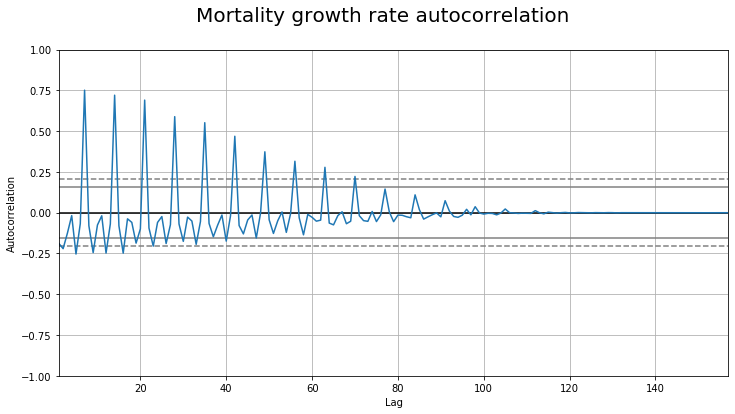

In [28]:
# Plotting new deaths growth rate autocorrelation

ax = plt.figure(figsize=(12,6))
ax.suptitle("Mortality growth rate autocorrelation", ha = "center", size=20)
autocorrelation_plot(df_sp["aceleracao_obitos"][1:])
ax = ax

We see the same trend for 7-day new deaths moving average, and so does the seasonality in the death growth rate autocorrelation. Let's repeat the analysis for the moving average of mortality growth rate.

In [29]:
# Creating new column for death growth rate moving average of 7 days

df_sp['media_movel_obitos_7_dias'] = df_sp['aceleracao_obitos'][1:].rolling(window=7,center=False).mean()

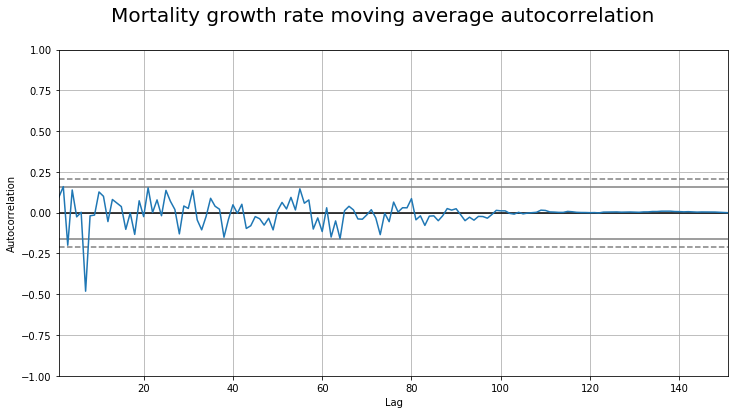

In [30]:
# Plotting death growth rate moving average of 7 days

ax = plt.figure(figsize=(12,6))
ax.suptitle('Mortality growth rate moving average autocorrelation',fontsize=20, ha = "center")
autocorrelation_plot(df_sp['media_movel_obitos_7_dias'][7:])
ax=ax

There is low autocorrelation for the moving average of mortality growth rate, but this is a side effect of smoothing the data along the days. We know that the death rate in the first lag is related to the value in the second lag, and so on. 

# Weekly seasonality

Seasonality is a data variation in specific regular time intervals. This pattern can happen within hours, days, weeks, months, years, and so on. 

To look at this effect, let's see how new death behaves throughout the week. First, we need to create a column with the day of the week.

In [31]:
# Creating weekday names column

df_sp['mes'] = pd.to_datetime(df_sp['data'])
df_sp['dia_da_semana'] = df_sp['mes'].dt.day_name() 
df_sp.head()

,semana,data,pais,estado,cidade,novosObitos,Obitos,novosCasos,Casos,obitosMS,...,suspeitos,testes,testes_por_100k,aceleracao_casos,aceleracao_obitos,media_movel_mortes_7_dias,media_movel_mortes_14_dias,mes,dia_da_semana,media_movel_obitos_7_dias
0,9,2020-02-25,Brazil,SP,TOTAL,0,0,1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-25,Tuesday,NaN
2,9,2020-02-26,Brazil,SP,TOTAL,0,0,0,1,0,...,NaN,NaN,NaN,-1.0,0.0,NaN,NaN,2020-02-26,Wednesday,NaN
4,9,2020-02-27,Brazil,SP,TOTAL,0,0,0,1,0,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,2020-02-27,Thursday,NaN
6,9,2020-02-28,Brazil,SP,TOTAL,0,0,1,2,0,...,NaN,NaN,NaN,1.0,0.0,NaN,NaN,2020-02-28,Friday,NaN
8,9,2020-02-29,Brazil,SP,TOTAL,0,0,0,2,0,...,NaN,NaN,NaN,-1.0,0.0,NaN,NaN,2020-02-29,Saturday,NaN


Now, we need to group the number of deaths, new deaths, and mortality growth rate by day of the week and take their mean.

In [32]:
# Grouping by day of the week

grouped_sp = df_sp.groupby('dia_da_semana')['Obitos','novosObitos','aceleracao_obitos'].mean().round()
grouped_sp['dia_da_semana'] = grouped_sp.index
grouped_sp.head(7)

,Obitos,novosObitos,aceleracao_obitos,dia_da_semana
dia_da_semana,,,,
Friday,7342.0,177.0,-13.0,Friday
Monday,6887.0,41.0,-20.0,Monday
Saturday,6786.0,155.0,-17.0,Saturday
Sunday,6846.0,60.0,-95.0,Sunday
Thursday,7165.0,190.0,9.0,Thursday
Tuesday,6794.0,206.0,175.0,Tuesday
Wednesday,6975.0,181.0,-25.0,Wednesday


In [33]:
# Reordering indexes

grouped_sp = grouped_sp.reindex(['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday',
                                    'Saturday'])

Text(0.5, 1.0, 'Mean new deaths by weekday')

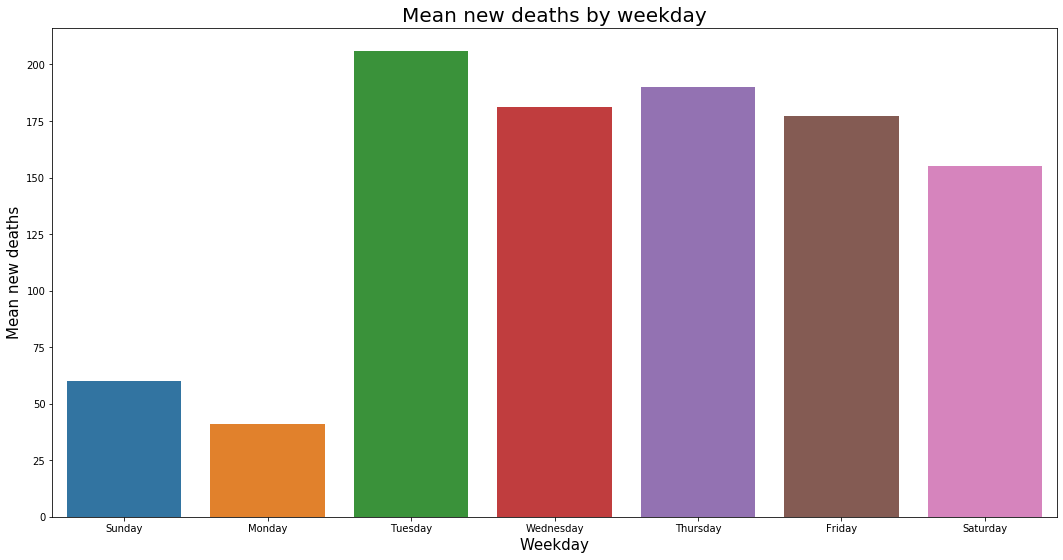

In [34]:
ax = sns.barplot(grouped_sp['dia_da_semana'], grouped_sp.novosObitos)
ax.figure.set_size_inches(18,9)
ax.set_xlabel("Weekday", fontsize=15)
ax.set_ylabel("Mean new deaths", fontsize=15)
ax.set_title("Mean new deaths by weekday", fontsize=20)

Sunday and Monday have fewer new death than the other five days in the week. Since the basic health units do not open on weekends and some hospitals and labs only work on duty, we expect Saturdays and Sundays to have these low numbers. This leads us to the conclusion of all the records are referred to the day before, and the consortium of press vehicles data is lagged by one day.

# Partial conclusions

After all these analyses, we can draw a few conclusions:
1. COVID-19 infections were slow in early 2020 and then skyrocketed in a couple of months, which is a case of exponential growth.
2. After July, the number of cases and new deaths are decreasing slowly. This could be a result of health efforts to understand how the disease works and how to treat the patient's symptoms in and out of the hospital.
3. We need to see how COVID-19 will behave and evolve in the future to take action more effectively and wait to see how the newly created vaccines will act against this virus. Until then, the number of new death could decrease to zero (in case of no virus' new mutations) or have a second or third wave soon (developing new virus mutations).
4. There is seasonality within a week since, on weekends, hospitals and labs only work as on duty, so it tends to have fewer new deaths.

# Time series predictions

## Time series decomposition

Decomposing a time series is a way to find and separate several components inside the dataset that, all added up, compose the observed data. We have mainly two types of seasonal components, additive and multiplicative. The additive is calculated by $Y(t) = T(t) + S(t) + e(t)$, where Y(t) is the observed data, T(t) is the trend, S(t) is the seasonal part, and e(t) is the noise, while the multiplicative one is compute by $Y(t) = T(t)*S(t)*e(t)$. By default, the model used in the seasonal_decompose method is the former one.

To make predictions using seasonal data, let's decompose them to look for tendencies, seasonality, noise, and residuals for SP, RJ, and MG states.

In [35]:
# Creating MG and RJ datasets

df_mg = df_filtered[df_filtered["estado"] == "MG"]
df_rj = df_filtered[df_filtered["estado"] == "RJ"]

In [36]:
df_sp["data"] = pd.to_datetime(df_sp['data'])
df_sp["data"] = pd.to_datetime(df_sp.data).dt.date
df_sp.index = pd.to_datetime(df_sp["data"])

df_mg["data"] = pd.to_datetime(df_mg['data'])
df_mg["data"] = pd.to_datetime(df_mg.data).dt.date
df_mg.index = pd.to_datetime(df_mg["data"])

df_rj["data"] = pd.to_datetime(df_rj['data'])
df_rj["data"] = pd.to_datetime(df_rj.data).dt.date
df_rj.index = pd.to_datetime(df_rj["data"])

In [37]:
# Decomposing the data

decomposition_sp = seasonal_decompose(df_sp["novosObitos"], freq = 7)
decomposition_mg = seasonal_decompose(df_mg["novosObitos"], freq = 7)
decomposition_rj = seasonal_decompose(df_rj["novosObitos"], freq = 7)

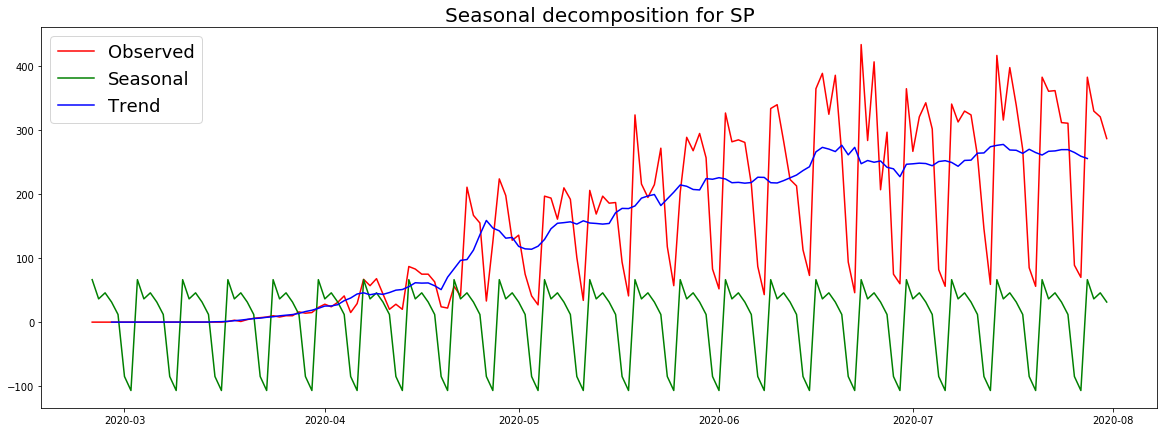

In [38]:
# Plotting seasonal decompose for SP

plotting(decomposition_sp.observed, decomposition_sp.seasonal, decomposition_sp.trend, "red", "green", "blue", "Observed", "Seasonal", "Trend", "SP")

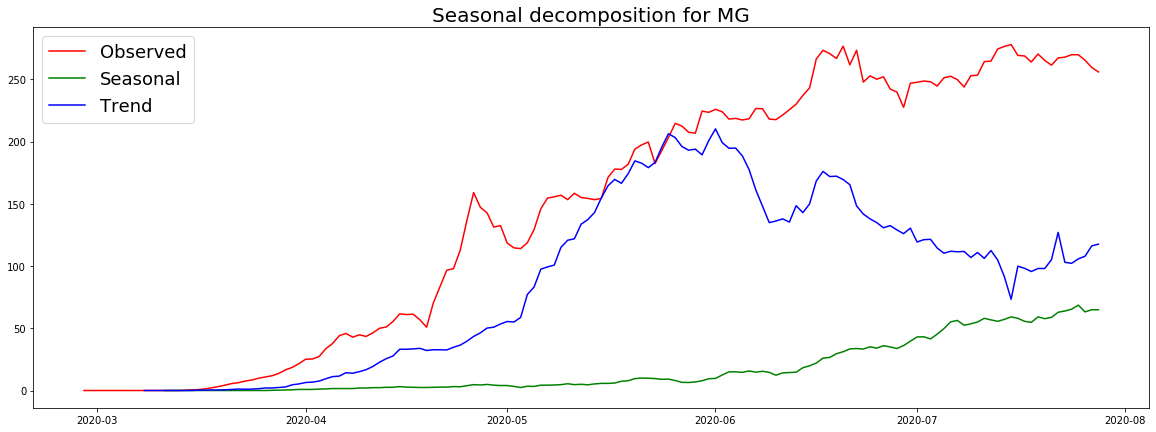

In [39]:
# Plotting trend for the three states

plotting(decomposition_sp.trend, decomposition_mg.trend, decomposition_rj.trend, "red", "green", "blue", "Observed", "Seasonal", "Trend", "MG")

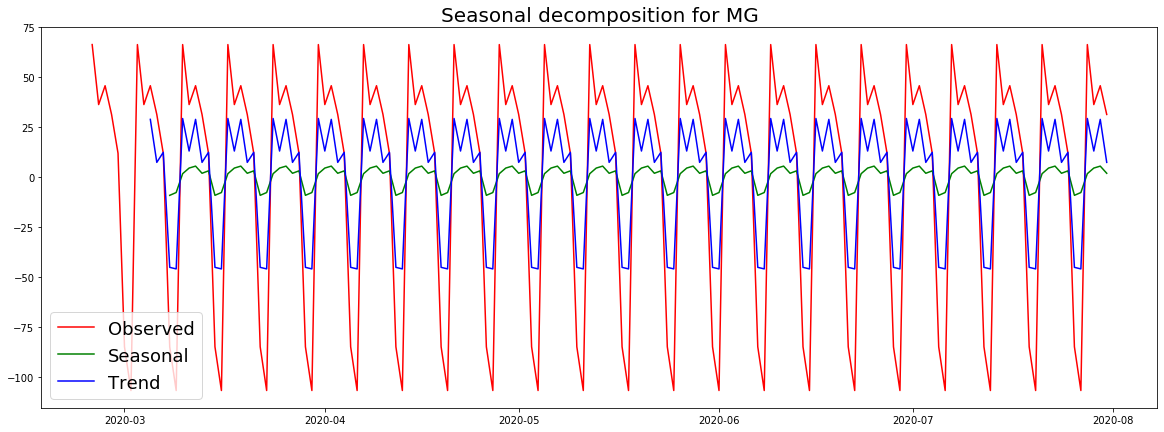

In [40]:
# Plotting seasonal for the three states

plotting(decomposition_sp.seasonal, decomposition_mg.seasonal, decomposition_rj.seasonal, "red", "green", "blue", "Observed", "Seasonal", "Trend", "MG")

We can see that the three states have different trends. SP had and still has higher values of all, RJ had a more accelerated trend, and now it has a downward one, and MG held lower numbers in the beginning, and now the numbers are increasing.

Looking at the seasonal parts, all three have the same pattern, which makes sense since all Brazilian states deliver the data daily and, at weekends, the registers are naturally lower.

This is a clue whether the dataset is stationary or not. We can verify this hypothesis via ADF - Augmented Dickey-Fuller test.

## Stationarity and differencing

Stationarity is when our time series have constant mean and variance over time. In other words, the data do not have any trend and/or seasonality. We can test this using the ADF test, which is A/B testing for a unit root, such as noise, in a univariate process. If the p-value is above a certain threshold, usually 0.05 (significance of 95%), we accept the null hypothesis (time series is not stationary and it is time-dependent). Otherwise, we accept the alternative hypothesis of the time series is stationary.

Differencing is the difference between two consecutive values, in our case, over time. It is possible to do it as many times as we want, to transform a non-stationary series into a stationary one. 

Let's check for stationarity and the differencing between the number of cases and the ACF plots.

In [41]:
# Creating a pandas series

y = df_sp["Casos"]
print(f"p-value for the number of cases: {adfuller(y.dropna())[1].round(4)}")

p-value for the number of cases: 0.997


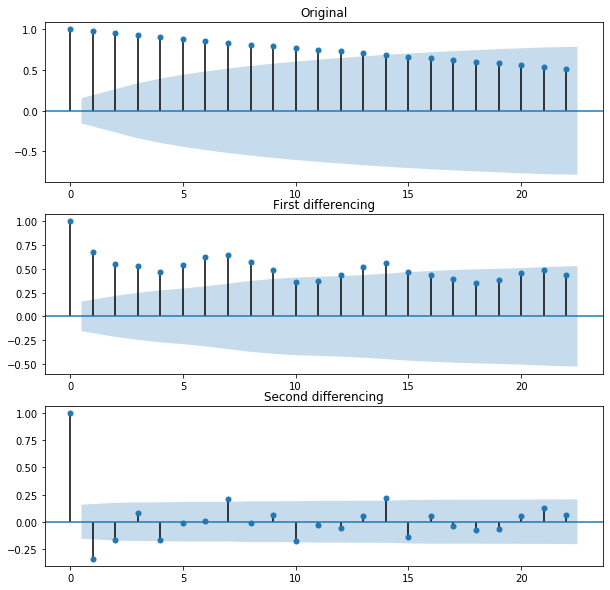

In [42]:
plotACF(y,y.diff().dropna(),y.diff().diff().dropna())

The p-value for the number of cases is 0.997, which is way higher than 0.05. This leads us to accept the null hypothesis and say that our time series is not stationary and it is time-dependent.

Also, the first ACF shows how autocorrelated the time series data are, which is very high. Then, in ACF for the first differencing the seasonality is highlighted due to the lowering of autocorrelation. The second differencing plot shows negative autocorrelation. This could be a sign of over-differencing, i.e., our time series is already stationary but it loses valuable information. To confirm this effect, let's plot the number of cases and its first and second differencing.

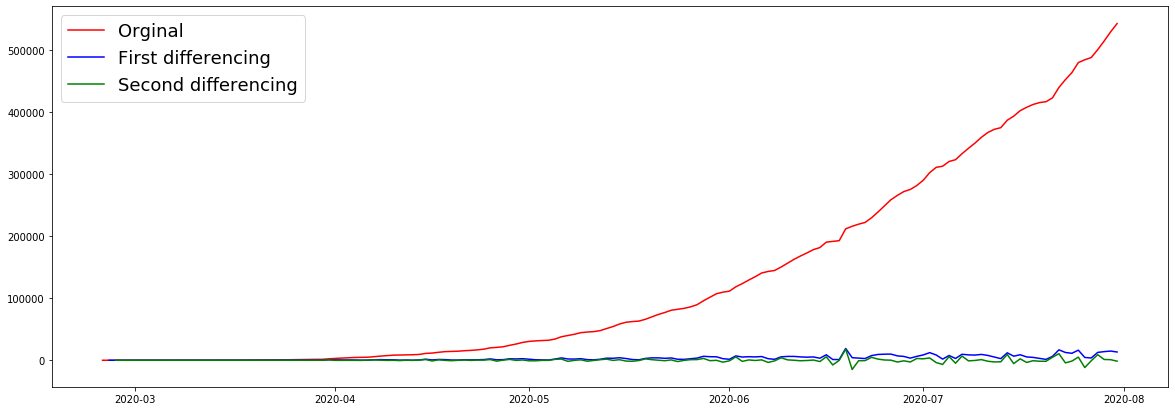

In [43]:
plotting(y, y.diff(), y.diff().diff(), "red", "blue", "green", "Orginal", "First differencing", "Second differencing")

The green and blue lines almost match each other all the time. Thus, the second differencing is not necessary, and it may impact our prediction model. This effect is confirmed when we check the partial autocorrelation below.

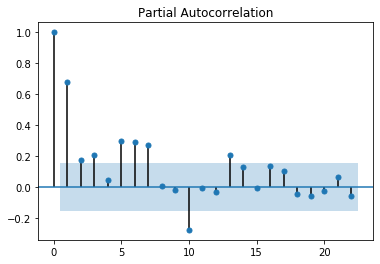

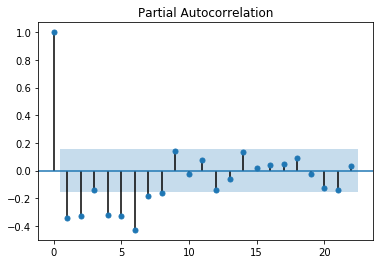

In [44]:
# Plotting partial autocorrelations for the number of cases

plot_pacf(y.diff().dropna());
plot_pacf(y.diff().diff().dropna());

The first graph shows the autocorrelation for the first differencing, and it still has some trace of seasonality. In the second one, it is clear the negative autocorrelations below the blueish that limit the significance.

## ARIMA model

ARIMA stands for Autoregressive integrated moving average, where autoregressive is a linear regression model (AR), moving average (MA) is also a linear regression using the past prediction errors, and integrated (I) or the differencing number that connects these two parts into one single model.

The autoregressive equation is:
$y_{t} = \phi_{0} + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} +  ... + \phi_{p}y_{t-p} + \epsilon$, where $\phi_{0}$ is the y-intercept, $\epsilon$ is the error term, $y_{t}$ is the linear regression equation, $y_{t-1}, y_{t-2}$ ... are the time series data, and $\phi{1}, \phi{2} ...$ are the regression coefficients.  

The moving average equation is given by:
$y_{t} = c + \epsilon_{t} + \theta_{1}\epsilon_{t-1} + \theta_{2}\epsilon_{t-2} +  ... + \theta_{p}\epsilon_{t-p} + \epsilon$, where c is a constant $\theta$ is regression coefficients and $\epsilon$ is the error of past predictions.

Finally, the integration term is I(d), which stands for the number of differencing to create a stationary time series.

To instantiate the ARIMA model, we need three terms: 
- q, related to moving average, which is the error in the prediction model or the moving average window, that is determined by the number of lags above the level of significance (blue-ish area) in the PACF graph;
- d, related to the integration part, which is the number of differencing to get a stationary time series.
- p, relate to the autoregressive part, which is the lag order or the number of lag observations, that is determined by the number of lag above significance (blue-ish area) on the ACF graph.

Due to the seasonal factor in our dataset, it will be hard to set the "correct" value of p, but there is a way to solve this problem, using the SARIMA model, which stands for Seasonal ARIMA. It has almost the same terms: (Q, P, D)m, which are seasonal q, p, and d respectively, and m is the number of steps in a single seasonal period.

To evaluate the ARIMA and SARIMA models, we will use Akaike Information Criteria (AIC) and Bayes Information Criteria (BIC) results. The AIC is given by AIC = $2k*2ln(\hat{L})$, where 
- $\hat{L}$ is the likelihood function for the model i.e. $\hat{L} = p(x|\hat{\theta}, M)$ where x is the observed data, $\hat{\theta}$ is the parameter value that maximize the likelihood function;
- n is the dataset size;
- k is the number of estimated parameters estimated by the model;
- x is the observed data.

Both results are based on cartesian distance. Thus the lower AIC and BIC, the better.

Looking back to the ACF and PACF graphs, let's build the simplest model, defining q=d=p=1 since our order lags are both one and the optimal number for differencing our time series is also 1.

In [45]:
# Building the model

arima = ARIMA(y, order=(1,1,1), freq="D")
model_fitted = arima.fit()
print(model_fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Casos   No. Observations:                  157
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1457.920
Method:                       css-mle   S.D. of innovations           2589.019
Date:                Tue, 06 Sep 2022   AIC                           2923.840
Time:                        22:57:47   BIC                           2936.065
Sample:                    02-26-2020   HQIC                          2928.805
                         - 07-31-2020                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          4784.0984   4361.904      1.097      0.273   -3765.076    1.33e+04
ar.L1.D.Casos     0.9966      0.005    215.190      0.000       0.988       1.006
ma.L1.D.Casos    -0.8462      0.040    -

It is complicated to define the model parameters one by one. But there is a way to automate this task and create several ARIMA models at once.

In [46]:
# Creating parameters range from 0 to 1

p=d=q=range(0,2)
pdq = list(itertools.product(p,d,q))
seasonal_pqd = [(x[0], x[1], x[2], 7) for x in pdq]

In [47]:
# Creating several SARIMAs models

aic_list = []
for param in pdq:
    for seasonal_param in seasonal_pqd:
        arima_model = sm.tsa.SARIMAX(y, order=param, seasonal_order=seasonal_param)
        results = arima_model.fit()
        aic_list.append("{} x {} - AIC = {}".format(param, seasonal_param, results.aic))

In [48]:
# Check the AIC values list

aic_list

['(0, 0, 0) x (0, 0, 0, 7) - AIC = 4312.204463385908',
 '(0, 0, 0) x (0, 0, 1, 7) - AIC = 4234.919433193501',
 '(0, 0, 0) x (0, 1, 0, 7) - AIC = 3562.871711196248',
 '(0, 0, 0) x (0, 1, 1, 7) - AIC = 3494.1582680755096',
 '(0, 0, 0) x (1, 0, 0, 7) - AIC = 3842.0341081191855',
 '(0, 0, 0) x (1, 0, 1, 7) - AIC = 3640.4087901836147',
 '(0, 0, 0) x (1, 1, 0, 7) - AIC = 3149.4455294937693',
 '(0, 0, 0) x (1, 1, 1, 7) - AIC = 3148.6560348217636',
 '(0, 0, 1) x (0, 0, 0, 7) - AIC = 4203.6371531581235',
 '(0, 0, 1) x (0, 0, 1, 7) - AIC = 4186.578948235653',
 '(0, 0, 1) x (0, 1, 0, 7) - AIC = 3367.0927927515695',
 '(0, 0, 1) x (0, 1, 1, 7) - AIC = 3273.0519366222034',
 '(0, 0, 1) x (1, 0, 0, 7) - AIC = 4175.643287397898',
 '(0, 0, 1) x (1, 0, 1, 7) - AIC = 4177.533546287512',
 '(0, 0, 1) x (1, 1, 0, 7) - AIC = 3401.8848163475104',
 '(0, 0, 1) x (1, 1, 1, 7) - AIC = 3405.7106517355533',
 '(0, 1, 0) x (0, 0, 0, 7) - AIC = 3140.724225355021',
 '(0, 1, 0) x (0, 0, 1, 7) - AIC = 3055.2982248356298',

Among the 64 AIC scores, the best was 2750 for the (1,1,1) x (1,1,1,7) setup, which will be used to build our final model.

In [49]:
# Building the final model

final_model = sm.tsa.statespace.SARIMAX(y, order=(1,1,1),
                                       seasonal_order=(1,1,1,7))
results = final_model.fit()

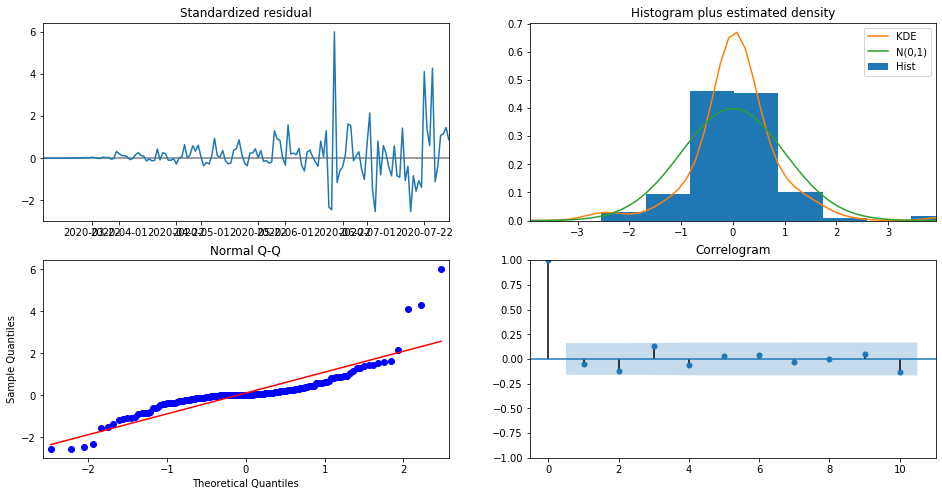

In [50]:
# Plotting the diagnostics

results.plot_diagnostics(figsize=(16,8))
plt.show()

The four graphs above give us some hints about the model and the data:

1. Standardized residual: the residuals have high oscillations as time passes as expected due to the exponential cases growth rate;
2. The histogram plus estimated density: it shows us the residual gaussian high spike around 0 (orange line), and there is no sign of kurtosis or skewness which means that the residuals are normally distributed and also confirms exponential growth of cases.
3. Normal Q-Q: most of the blue dots (data) are close to the red line (model). Thus the model fitted our records.
4. Correlogram: the residual autocorrelation are low (within the blue-ish area) which means that we successfully transformed our time series into a stationary one.

## Cases prediction

To make predictions, we will use July as a "train set" just like in supervised algorithms. To do so, we set the start parameter as 07-01-2020.

In [51]:
# Building model predictions

prediction = results.get_prediction(start = pd.to_datetime('07-01-2020'), dynamic=False)
pred_confiance_interval = prediction.conf_int()

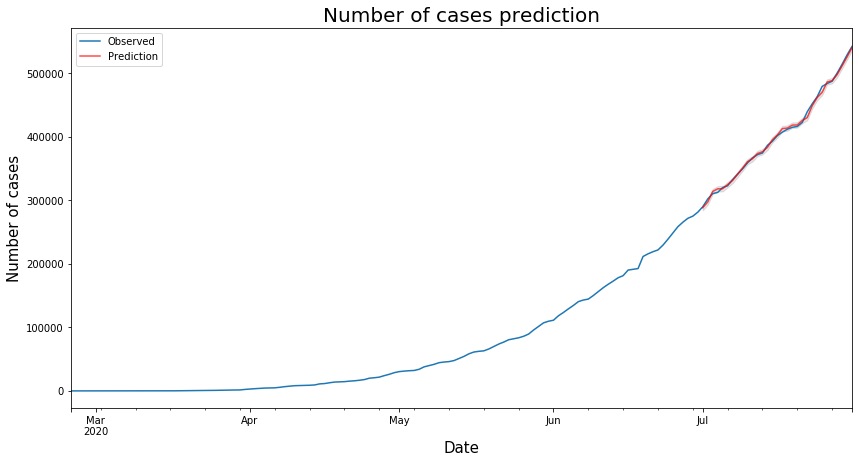

In [52]:
# Plotting the predictions and confidence interval

ax = y["2020":].plot(label="Observed")
prediction.predicted_mean.plot(ax=ax, label="Prediction", color="r", alpha=0.7, figsize=(14,7))
ax.fill_between(pred_confiance_interval.index, pred_confiance_interval["lower Casos"], pred_confiance_interval["upper Casos"], color = "k", alpha = 0.1)
ax.set_ylabel("Number of cases", fontsize=15)
ax.set_xlabel("Date", fontsize=15)
ax.set_title("Number of cases prediction", fontsize=20)
plt.legend()

The confidence interval (grayish area) is small because the same data was used as a "training set". Let's see how it predicts the future. 

In [53]:
# Forecasting

forecast_uc = results.get_forecast(steps=160)
forecast_ic = forecast_uc.conf_int()

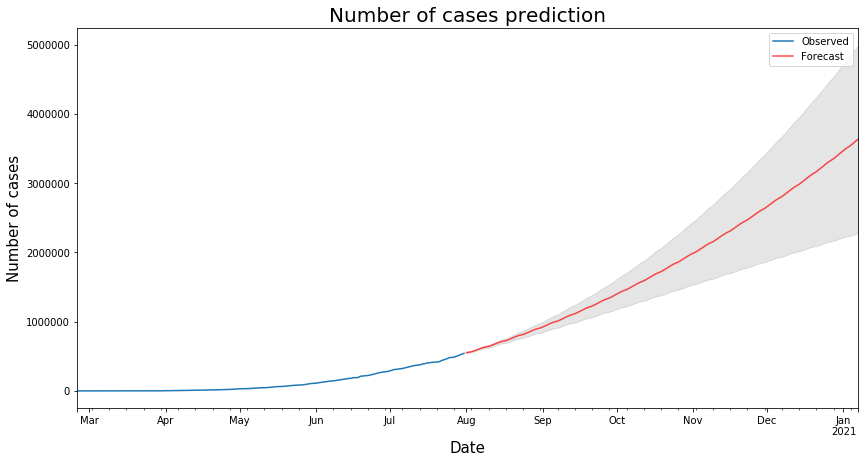

In [54]:
# Plotting the forecast

ax = y.plot(label="Observed")
forecast_uc.predicted_mean.plot(ax=ax, label="Forecast", color="r", alpha=0.7, figsize=(14,7))
ax.fill_between(forecast_ic.index, forecast_ic["lower Casos"], forecast_ic["upper Casos"], color = "k", alpha = 0.1)
ax.set_ylabel("Number of cases", fontsize=15)
ax.set_xlabel("Date", fontsize=15)
ax.set_title("Number of cases prediction", fontsize=20)
plt.legend()

## Update data comparison

Let's compare the forecast with records until December 31st, 2020.

In [55]:
# Reading the updated data

df_update = pd.read_csv("c:\cases-brazil-states-att.csv")
df_update = df_update[df_update["state"] == "SP"]
df_update["date"] = pd.to_datetime(df_update["date"]).dt.date
df_update.index = df_update["date"]

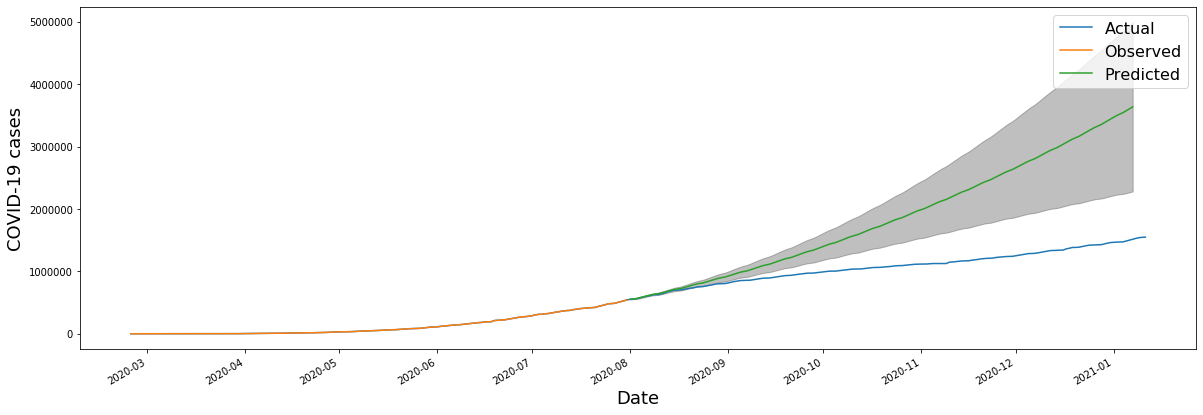

In [56]:
# Plotting the forecast and the updated data

x = df_update["totalCases"]
plt.figure(figsize=(20,7))
fig = plt.plot(x,label="Actual")
ax = y.plot(label="Observed")
forecast_uc.predicted_mean.plot(ax=ax, label="Predicted")
ax.fill_between(forecast_ic.index, forecast_ic.iloc[:,0],forecast_ic.iloc[:,1], color='k',alpha=0.25)
ax.set_xlabel("Date",fontsize=18)
ax.set_ylabel("COVID-19 cases",fontsize=18)
plt.legend(fontsize=16)

The graph above shows us a couple of things: 
- the model did well in the first 30 days;
- the number of cases flatted due to sanitary measures such as social distancing, face masks, and lockdowns;
- the higher the steps we set to predict, the bigger the confidence interval will be because it is hard to predict far in the future.

## Mortality prediction

Let's do the same prediction and forecast for mortality.

In [57]:
# Selecting daily new deaths

mort_300 = df_update[0:300] 
y_mort = mort_300["newDeaths"]

In [58]:
# Setting the SARIMA parameters

p = d = q = range(0,2)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p,d,q))]

In [59]:
# Creating several SARIMAs models

aic_list_mort = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        model = sm.tsa.statespace.SARIMAX(y_mort,
                                       order=param,
                                       seasonal_order=param_seasonal)
        results = model.fit()
        aic_list_mort.append("ARIMA{}x{} - AIC - {}".format(param, param_seasonal, results.aic))

aic_list_mort

['ARIMA(0, 0, 0)x(0, 0, 0, 7) - AIC - 4017.1944378824282',
 'ARIMA(0, 0, 0)x(0, 0, 1, 7) - AIC - 3759.9849845635226',
 'ARIMA(0, 0, 0)x(0, 1, 0, 7) - AIC - 3285.0200137893753',
 'ARIMA(0, 0, 0)x(0, 1, 1, 7) - AIC - 3234.8580077623137',
 'ARIMA(0, 0, 0)x(1, 0, 0, 7) - AIC - 3368.8097880892046',
 'ARIMA(0, 0, 0)x(1, 0, 1, 7) - AIC - 3323.050919538077',
 'ARIMA(0, 0, 0)x(1, 1, 0, 7) - AIC - 3238.5985903037936',
 'ARIMA(0, 0, 0)x(1, 1, 1, 7) - AIC - 3234.3142899964287',
 'ARIMA(0, 0, 1)x(0, 0, 0, 7) - AIC - 3840.136316091938',
 'ARIMA(0, 0, 1)x(0, 0, 1, 7) - AIC - 3666.3970533502466',
 'ARIMA(0, 0, 1)x(0, 1, 0, 7) - AIC - 3286.3636014078693',
 'ARIMA(0, 0, 1)x(0, 1, 1, 7) - AIC - 3236.5104088677454',
 'ARIMA(0, 0, 1)x(1, 0, 0, 7) - AIC - 3370.7699981745964',
 'ARIMA(0, 0, 1)x(1, 0, 1, 7) - AIC - 3324.227466404629',
 'ARIMA(0, 0, 1)x(1, 1, 0, 7) - AIC - 3240.500239529436',
 'ARIMA(0, 0, 1)x(1, 1, 1, 7) - AIC - 3236.154529403908',
 'ARIMA(0, 1, 0)x(0, 0, 0, 7) - AIC - 3712.2554406569598',
 '

The best AIC is 3462 for (1,1,1) x (0,1,1,7). Let's build the model with these parameters.

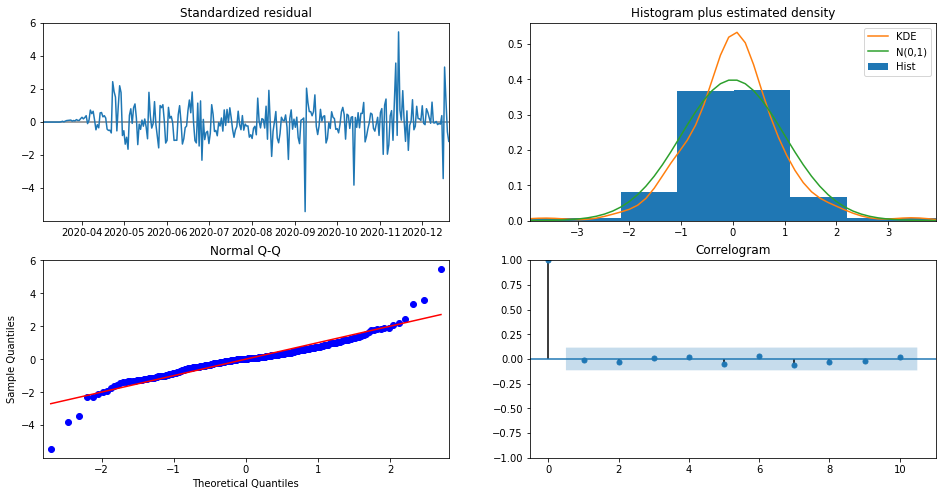

In [60]:
final_model = sm.tsa.statespace.SARIMAX(y_mort, order=(1,1,1), seasonal_order = (0,1,1,7))
results = final_model.fit()
results.plot_diagnostics(figsize=(16,8))
plt.show()

The four graphs above give us some hints about the model and the data:

1. Standardized residual: the residuals are evenly distributed around the 0 because we are dealing with new deaths and not with accumulated data;
2. The histogram plus estimated density: the orange line is close to the green one, which means that the residuals are normally distributed;
3. Normal Q-Q: most of the blue dots (data) are close to the red line (model), thus the model fitted our records, similar to the number of cases model;
4. Correlogram: the residual autocorrelation are low (within the blue-ish area) which means that we successfully transformed our time series into a stationary one.

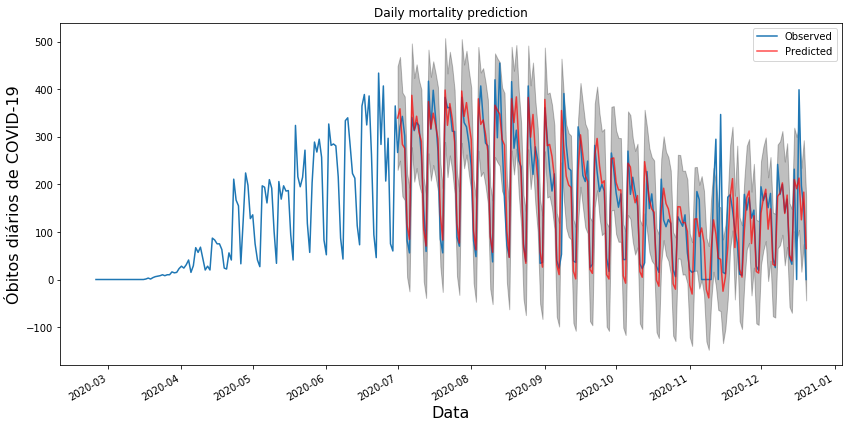

In [61]:
# Plotting the predictions and confidence interval

plt.figure(figsize=(14,7))
pred = results.get_prediction(start=pd.to_datetime("2020-07-01"),dynamic=False)
pred_ci = pred.conf_int()
ax = y_mort.plot(label="Observed")
pred.predicted_mean.plot(ax=ax, label="Predicted", color="r", alpha=0.7)
ax.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], color="k",alpha=0.25)
plt.legend()
ax.set_xlabel("Data",fontsize=16)
ax.set_ylabel("Óbitos diários de COVID-19",fontsize=16)
ax.set_title("Daily mortality prediction")
plt.show()

Considering the confidence interval, the model did well except for three or four times. Let's use this model to forecast our data.

Text(0, 0.5, 'Mortality')

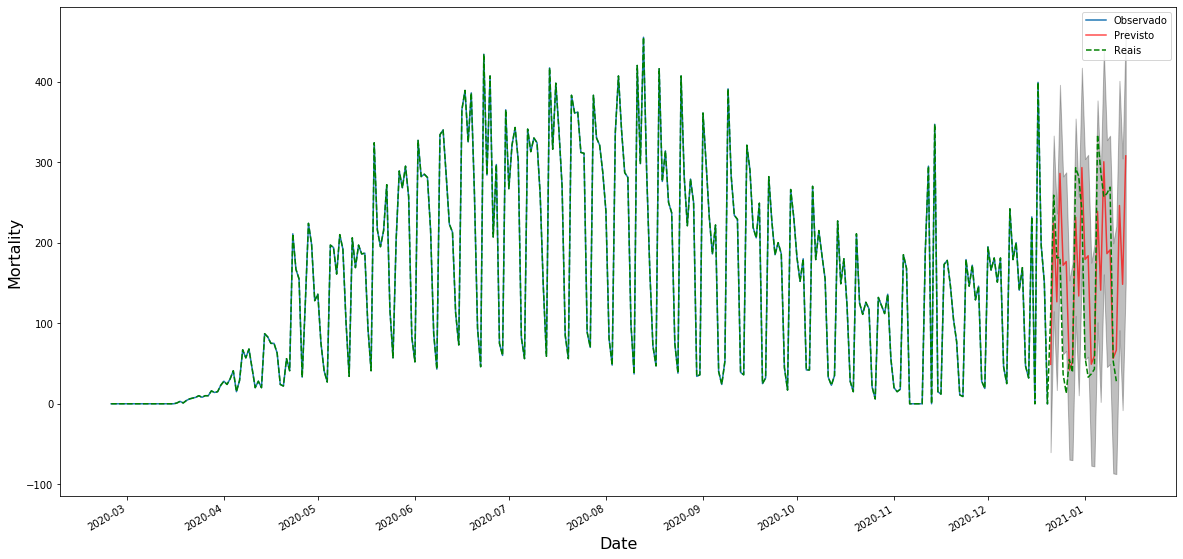

In [62]:
# Forecasting for 25 days

x_mort = df_update["newDeaths"]
pred_uc = results.get_forecast(steps = 25)
pred_ci = pred_uc.conf_int()
ax = y_mort.plot(label="Observado",figsize=(20,10))
pred_uc.predicted_mean.plot(ax=ax, label="Previsto", color="r", alpha=0.7)
ax.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1],color="k",alpha=0.25)
fig = plt.plot(x_mort,linestyle='--',color="green",label="Reais")

plt.legend()
ax.set_xlabel("Date",fontsize=16)
ax.set_ylabel("Mortality",fontsize=16)

For the next 25 days, the model performed well, but there is a seasonal delay of a couple of days due to the methodology the Brazilian government and the consortium of press vehicles data use to compile data.

# Conclusions

Finally, we can draw some conclusions:
1. COVID-19 infections had exponential growth.
2. After July, sanitary efforts started to flatten the growth rate. 
3. There is seasonality within a week since, on weekends, hospitals and labs only work as on duty, so it tends to have fewer new deaths on these days.
4. The number of cases forecast did well within the first month and it becomes harder to predict.
5. The mortality forecast predicted the actual daily new deaths with some delay within the confidence interval and it shows us a second wave coming for early 2021.